<a href="https://colab.research.google.com/github/PederRonning/sok-3023/blob/main/Veldig_ferdig.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Shipping Index Forecasting with SARIMAX and LSTM  

Er shipping indeksen forutsigbar en dag eller en uke før i tid? Hvor bra kan en LSTM modell predikere indeksen sammenlignet med en mindre kompleks SARIMAX modell.

Shipping priser kan bestemmes av en rekke faktorer. Geopolitisk aktivitet, makroøkonomiske trender, råvarepriser og sesongbasert etterspørsel kan være avgjørende for aksjeprisene til de mange shipping selskapene listet på Oslo børs. Det er derfor vi har tatt for oss historiske verdier for Oslo Børs Shipping indeks (SSSHX) fra investing.com i møte med vår analyse av problemstillingen. I tillegg til dette er det mye som tyder på at utgiftene i shipping sektoren kan knyttes til oljeprisen og dermed har mye å si for indeksen. Bunkerolje er den største utgiften og står for nesten 50% av reisekostnadene. Bunkeroljen er også tett knyttet til prisen av crude oil (Choi & Yoon, 2020). Dette er grunnen til at vi også har inkludert «WTI crude oil prices» i våre modeller. Begge datasettene strekker seg fra 08.01.2020 til 26.02.2025 og er hentet fra investing.com. ChatGPT og Gemini er brukt som hjelpemidler til koding i denne oppgaven. Mye av koden er også inspirert av "Forelesning 6 - Long Short Term Memory modeller" (Aase, 2025).


En syklisk aksje er en aksje som går veldig i takt med den økonomiske utviklingen til et samfunn. Dersom arbeidsledigheten er lav med høy aktivitet i næringslivet vil det også gå bra med sykliske selskap. Dersom det er høy arbeidsledighet med mindre aktivitet i næringslivet, vil sykliske selskaper være dårligere. Dette gjør at det kan være lettere å forutsi sykliske aksjer (Krohn, 2021).

In [3]:
# Installere eventuell ekstern pakke (pmdarima) – ignorerer hvis den finnes
# imports
import random, os, math, datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import tensorflow as tf
from tensorflow.keras import layers, callbacks, models, optimizers

# Reproduserbarhet, brukes for å oppnå de samme verdiene til eks: RMSE
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


## 1  Dataset og problemstilling

Datasettene er begge hentet fra investing.com og har relativt like strukturer. Det første er Oslo Shipping Index som er indeksen til de børsnoterte norske shipping selskapene. Sammen med «WTI Crude-oil futures settlement price», som oppgir oljeprisen over tid. Datasettene har amerikanske datoformat og en variabel for pris hvor tusener er separert ved komma.

In [4]:
# Laster inn dataen
shipping_csv = "OSLO Shipping Historical Data.csv"
oil_csv      = "Crude Oil WTI Futures Historical Data.csv"
# Gjør om til df
df  = pd.read_csv(shipping_csv)
oil = pd.read_csv(oil_csv)

# Datasettene har amerikanske datoformat og en variabel for pris hvor tusener er separert ved komma.
for d in (df, oil):
    d['Date']  = pd.to_datetime(d['Date'], format='%m/%d/%Y')
    d['Price'] = (d['Price'].astype(str)
                            .str.replace(',', '', regex=False)
                            .astype(float))

df  = df.rename(columns={'Price': 'ShipPrice'})
oil = oil.rename(columns={'Price': 'OilPrice'})

# lager et samlet datasett
merged = (pd.merge(df, oil, on='Date', how='inner')
            .sort_values('Date')
            .reset_index(drop=True))

merged.head() # viser strukturen


,Date,ShipPrice,Open_x,High_x,Low_x,Vol._x,Change %_x,OilPrice,Open_y,High_y,Low_y,Vol._y,Change %_y
0,2020-01-08,223.10,222.60,224.40,222.03,NaN,0.24%,59.46,62.63,65.40,58.99,436.61K,-4.88%
1,2020-01-09,224.37,223.52,225.16,223.04,NaN,0.57%,59.44,59.85,60.17,58.55,268.85K,-0.03%
2,2020-01-10,225.60,224.37,227.36,224.27,NaN,0.55%,58.99,59.51,59.67,58.79,256.06K,-0.76%
3,2020-01-13,225.23,225.60,226.93,224.47,NaN,-0.16%,58.08,59.08,59.21,57.93,295.82K,-1.54%
4,2020-01-14,223.28,225.19,226.29,222.79,NaN,-0.87%,58.26,58.06,58.73,57.74,262.79K,0.31%


## 2  Dataforståelse og preprosessering

In [5]:
# Utforsker datasettet
print(merged.describe())

# Konverter til tidsserie
merged = merged.set_index('Date').asfreq('B') # asfreq('B') gjør om til "business day", ekskluderer helger
merged = merged.ffill()    # fyll av evtentuelle hull

# Skalerer prisene [0,1] for LSTM, ved bruk av min-max scaler (Zhang, 2024).
scaler = MinMaxScaler()
merged[['ShipPrice_scaled', 'OilPrice_scaled']] = scaler.fit_transform(
    merged[['ShipPrice', 'OilPrice']] # viktig for at de "høye" shipping prisene (NOK) ikke dominerer oljeprisene (USD)
)
merged.head() # for oversikt


                                Date    ShipPrice     OilPrice       Open_y  \
count                           1291  1291.000000  1291.000000  1291.000000   
mean   2022-07-30 21:43:55.166537728   458.083950    70.857816    70.874012   
min              2020-01-08 00:00:00   122.180000    11.570000    18.010000   
25%              2021-04-21 12:00:00   223.125000    63.565000    63.620000   
50%              2022-08-02 00:00:00   394.740000    73.420000    73.600000   
75%              2023-11-07 12:00:00   703.715000    81.030000    81.000000   
max              2025-02-26 00:00:00  1028.350000   119.780000   120.660000   
std                              NaN   269.789889    18.828727    18.830305   

            High_y        Low_y  
count  1291.000000  1291.000000  
mean     72.112006    69.558954  
min      19.660000     6.500000  
25%      64.855000    62.575000  
50%      74.720000    72.460000  
75%      82.040000    80.040000  
max     126.420000   118.520000  
std      19.1253

,ShipPrice,Open_x,High_x,Low_x,Vol._x,Change %_x,OilPrice,Open_y,High_y,Low_y,Vol._y,Change %_y,ShipPrice_scaled,OilPrice_scaled
Date,,,,,,,,,,,,,,
2020-01-08,223.10,222.60,224.40,222.03,NaN,0.24%,59.46,62.63,65.40,58.99,436.61K,-4.88%,0.111370,0.442565
2020-01-09,224.37,223.52,225.16,223.04,NaN,0.57%,59.44,59.85,60.17,58.55,268.85K,-0.03%,0.112771,0.442381
2020-01-10,225.60,224.37,227.36,224.27,NaN,0.55%,58.99,59.51,59.67,58.79,256.06K,-0.76%,0.114129,0.438222
2020-01-13,225.23,225.60,226.93,224.47,NaN,-0.16%,58.08,59.08,59.21,57.93,295.82K,-1.54%,0.113720,0.429812
2020-01-14,223.28,225.19,226.29,222.79,NaN,-0.87%,58.26,58.06,58.73,57.74,262.79K,0.31%,0.111568,0.431476


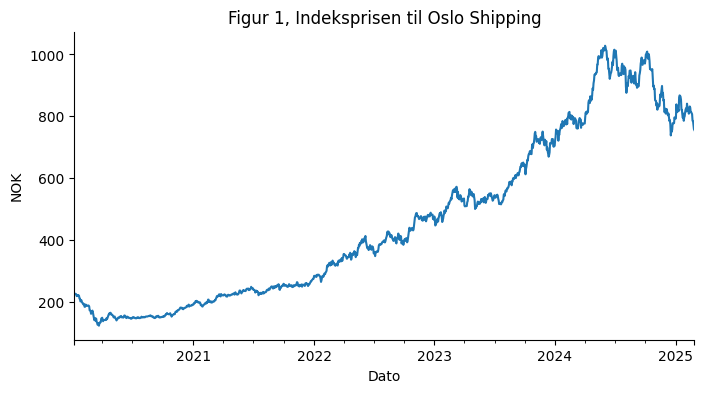

In [6]:
# plotter raw data, Gemini plot

merged['ShipPrice'].plot(kind='line', figsize=(8, 4), title='Figur 1, Indeksprisen til Oslo Shipping')
plt.xlabel('Dato')
plt.ylabel('NOK')
plt.gca().spines[['top', 'right']].set_visible(False)

Figur 1 viser lukningsprisen for Oslo Børs Shipping indeks over tid, det har vært en betydelig økning siden 2020.

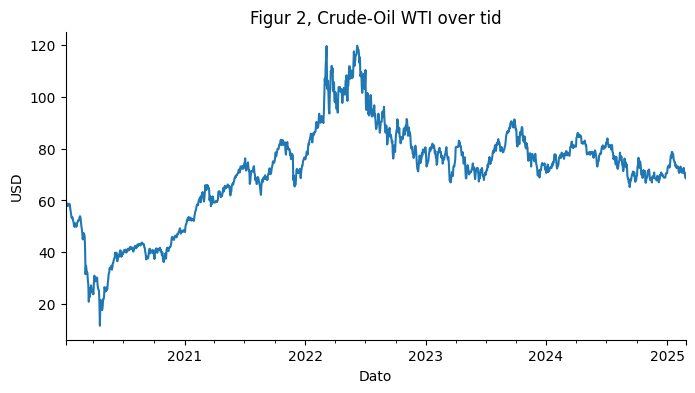

In [7]:
# Gemini plot
merged['OilPrice'].plot(kind='line', figsize=(8, 4), title='Figur 2, Crude-Oil WTI over tid')
plt.xlabel('Dato')
plt.ylabel('USD')
plt.gca().spines[['top', 'right']].set_visible(False)

Figur 2 viser oljeprisen over tid. Utviklingen har vært relativt konstant de siste 2 årene.

«merged» datasettet blir sortert kronologisk og indeksen blir gjort om til en «B» for business day for å ekskludere de mange helgene inkludert i datasettet, hvilket er viktig for presisjon hos modellene.

Prisene for treningssettet blir skalert ned til verdier mellom 0 og 1 via min-max scaler. Dette hindrer de «høye» shipping prisene å dominere de mindre oljeprisene. Dette kommer av at førstnevnte er listet i NOK og oljeprisen er listet i USD.
Disse stegene gjør at vi ender opp med et ryddigere datasett med 1341 observasjoner fra 8 januar 2020 til 26 februar 2025, uten noen NA-verdier og to skalerte priskolonner. Et slikt datasett hjelper robustheten til både den mindre komplekse SARIMAX modellen, samt dyplærings LSTM-modellen.


### Vindugenerering for LSTM

Implementasjon av modeller:
I denne oppgaven er long short-term memory (LSTM) dyplæringsteknikken vi tar for oss. LSTM er en viderebyggelse av recurrent neural networks (RNN). RNN er en tidsseriemodell, altså den tar hensyn til data over tid, i stedet for å gjøre det i ett steg. En RNN modell består av fire komponenter. Inputen føres til beregnings nevronet hvor informasjonen lagres som en output. Den lagrede outputen tilbakevender deretter til beregnings nevronet. Det er denne delen som gjør RNN spesiell iforhold til andre tradisjonelle nevrale nettverk. Problemet med RNN er at det ofte kan ha et problem med long term dependencies. Dette vil si at desto mer informasjon modellen lagrer, vil det bli vanskeligere og vanskeligere og lære seg ny informasjon. Her kommer LSTM inn i bildet. LSTM modellen tar hensyn til dette problemet ved å legge til flere komponenter som 3 ulike porter (forget, input, output) og en celle tilstand $C_t$. De tre ulike portene gjør som følger; forget gaten velger hva av informasjon som eksisterte i $C_{t-1}$ som skal glemmes og forkastes. Input gaten ser over all informasjon av den nye inputen og velger hva som skal lagres i cellen. Output gaten velger hva av informasjonen i cellen som sendes videre til neste celle (Aase, 2024).


In [8]:
# det å definere en windowed_df er "hovedsteget" i lstm
# Vi har tatt inspirasjon fra Gregg Hogg og Zhang (2024).
# siden vi har en multivariat time series model må vi tilpasse dataen for en LSTM
def df_to_windowed(df, lookback=3, target_col='ShipPrice_scaled'): # lookback=3, past time steps i input window
    X, y, dates = [], [], [] # X, y, dates for valgt target‑kolonne, den skalerte prisen
    for i in range(len(df) - lookback): # hent et window fra lookback lengden
        window = df.iloc[i : i + lookback]
        X.append(window[['ShipPrice_scaled', 'OilPrice_scaled']].values) #de skalerte prisene som lookback x2 matrise
        y.append(df[target_col].iloc[i + lookback]) # target = neste shipping index value t+1
        dates.append(df.index[i + lookback]) # for å beholde datoene for senere plots
    return np.array(X), np.array(y), np.array(dates) # returnerer i form av numpy arrays

# tester
LOOKBACK = 3 # velger window lendge
X, y, dates = df_to_windowed(merged, LOOKBACK)
print(f'X shape: {X.shape}, y shape: {y.shape}')


X shape: (1338, 3, 2), y shape: (1338,)


Koden vår lager et vindu med lengde $L = 3$ som stopper på tid $t$ og prøver å predikere morgendagen $y_{t+1}$. Modellen ser dagens oljepris $x_t$, men vet aldri $y_{t+1}$ eller $x_{t+1}$ under treningen og prediskjonen. Dette er viktig for at modellen ikke skal kunne se inn i fremtiden og for å unngå look-ahead bias.

### Train / Val / Test‑split

In [9]:
# tidsserier blir splittet slik at modellen trenes på fortiden og evalueres på fremtiden
q80 = int(len(dates) * .80) #for treningsdataen
q90 = int(len(dates) * .90) # for evalueringen

dates_train, X_train, y_train = dates[:q80], X[:q80], y[:q80] # parameterene trenes
dates_val,   X_val,   y_val   = dates[q80:q90], X[q80:q90], y[q80:q90] # validering
dates_test,  X_test,  y_test  = dates[q90:],    X[q90:],    y[q90:] # testing

print(f'Train: {X_train.shape},  Val: {X_val.shape},  Test: {X_test.shape}')


Train: (1070, 3, 2),  Val: (134, 3, 2),  Test: (134, 3, 2)


##  Modell 1 — SARIMAX

ARIMA (0,1,0) modellen har 0 auto regressive parametere, noe som betyr at den nåværende verdien ikke kan bli forklart av verdien den har hatt en eller flere tidsserier tilbake (Shumway & Stoffer, 2017, s. 75).
Modellen inkluderer 1 integrert verdi, noe som betyr at modellen er stasjonær i første differanse. Dette måtte gjøres ettersom at den ikke var stasjonær opprinnelig.
Deretter har modellen 0 moving average. 0 MA ble valgt ettersom at BIC’en hadde lavere verdi sammenlignet med 1 MA.


Verdiene forklart til nå er ARIMA. S står for seasonal. Det er her de fire resterende orderne kommer inn, SARIMA (0,1,0) x (1,0,[1],5). De tre første nye nummerene er sesongvise versjoner av ARIMA’en. Den siste orderen er 5 som står for en ukentlig trading syklus. 5 trading dager i uken (Mehandzhiyski, 2023).
Til slutt er det kun X’en igjen som gjenstår for å fullføre SARIMAX modellen. X’en står for eksogene variabler som påvirker vår endogene variabel. Olje pris er en eksogen variabel vi bruker (Mehandzhiyski, 2023).


In [10]:
#SARIMAX trenes KUN på data frem til 2023-12-31
sarimax_train_end = "2023-12-31" # definerer cut-off dato

sarimax_y_train  = merged['ShipPrice'].loc[:sarimax_train_end] # kutter merged i to, en for target / indeksen
sarimax_exo_train = merged['OilPrice'].loc[:sarimax_train_end] # en for den eksogene faktoren / oljeprisen

# definere SARIMAX modellen med de to pandas datasettene
sarimax_model = SARIMAX(
    sarimax_y_train,
    exog=sarimax_exo_train,
    order=(0,1,0), # setter order til 0,1,0, first difference, uten AR/MA terms
    seasonal_order=(1,0,1,5) # legger til en seasonal AR og en MA=5 term pga ukentlige handelsdager, man-fre
)
sarimax_fitted = sarimax_model.fit() # estimerer koeffisienter basert på max Log Likelihood
print(sarimax_fitted.summary()) # viser output

                                      SARIMAX Results                                      
Dep. Variable:                           ShipPrice   No. Observations:                 1038
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 5)   Log Likelihood               -3305.889
Date:                             Tue, 06 May 2025   AIC                           6619.778
Time:                                     07:49:02   BIC                           6639.554
Sample:                                 01-08-2020   HQIC                          6627.281
                                      - 12-29-2023                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
OilPrice       0.5219      0.070      7.412      0.000       0.384       0.660
ar.S.L5       -0.6547      

Ut ifra resultatene til SARIMAX modellen ovenfor kan vi se hvordan oljeprisen påvirker daglige endringer i indeksprisen. Ettersom dataen er differensiert d = 1, kan vi lese ut ifra koeffisienten at for hver enhets økning i oljepris (USD), øker indeksprisen med ≈ 0.52 NOK. Modellen påstår igjennom sitt 95% konfidensintervall, at økningen vil være mellom 0.384 til 0.660 NOK. ar.S.L5 har en signifikant verdi på ≈ -0.65 noe som betyr at prisen er "mean-reverting". Dette betyr at om indeksen avviker fra sin gjennomsnitspris, har den en tendens til å reverseres tilbake til sitt historiske gjennomsnitt. (Westrum et al.,  2022, s.9). Den sesongmessige tilsvarende MA koeffisienten har en verdi på ≈ 0.72, noe som viser at rundt 72% av forrige ukes sjokk påvirker fortsatt dagens avkastning.


In [11]:
# Forecast 2024-01-02 til slutten av datasettet, gjøres for å kunne lettere sammenligne med lstm.
sarimax_pred_start = "2024-01-02" # setter en start dato for prediksjonene, første handelsdag i 2024
sarimax_pred_end   = merged.index[-1] # sluttdato

sarimax_exo_pred = merged['OilPrice'].loc[sarimax_pred_start:sarimax_pred_end] #hent tilsvarende eksogene "regressor"

# generer prediksjoner basert på den eksogene variabelen. Produserer både punkt prediksjoner og CI
sarimax_fc = sarimax_fitted.get_forecast(
    steps=len(sarimax_exo_pred), # lengde
    exog=sarimax_exo_pred # fremtidige oljepriser
)

#lagrer predikert gjennomsnitt og det faktisk observerte gjennomsnittet for plottet senere
sarimax_pred  = sarimax_fc.predicted_mean
sarimax_truth = merged['ShipPrice'].loc[sarimax_pred_start:sarimax_pred_end]

##   Modell 2 — LSTM

In [12]:
# sequence-to-one lstm model
lstm_model = models.Sequential([
    layers.Input((LOOKBACK, 2)), # timesteps
    layers.LSTM(64), #64 memory cells
    layers.Dense(32, activation='relu'),
    layers.Dense(1) # lineært
])

# treningsprosessen
lstm_model.compile(
    loss='mse', # mean-squared error
    optimizer=optimizers.Adam(learning_rate=1e-3), # adaptive SGD # Aase (2024).
    metrics=['mae'] #tracker mean-absolute error
)
# setter opp early stopping, stop etter 5 epochs uten fremgang.
early = callbacks.EarlyStopping(patience=5, restore_best_weights=True)
#restore_best_weights, går tilbake til laveste val-loss.

#trener netverket
history = lstm_model.fit(
    X_train, y_train, # 80%
    validation_data=(X_val, y_val), #10
    epochs=200, #øvre grense epochs
    callbacks=[early], # aktiverer early stopping
    verbose=0   # skrur av spam i output
)


Cellen ovenfor lager en bivariate LSTM som trenes under visse reguleringer for å skape en model som kan bruke både tidligere indekspriser og nåværende oljepriser, samtidig som å unngå over-fitting. Modellen ser på to tidsserier parallelt og predikerer en fremtidig observasjon, noe som kan definere modellen vår som en bivariate sequence-to-one LSTM model.

In [13]:
# Prediksjon på testsett
lstm_pred_scaled = lstm_model.predict(X_test).flatten() #sender X_test igjennom treningsnettverket
# flatten() konverterer 2-D outputen til en array 1-D.

# Inverterer skalering tilbake til NOK
lstm_pred = scaler.inverse_transform(
    np.column_stack([
        lstm_pred_scaled,                     # ShipPrice_scaled
        merged['OilPrice_scaled'].iloc[-len(lstm_pred_scaled):] # tilsvarende skalerte oljepriser
    ])
)[:,0] # behold kun den første kolonnen
# siden den orginale skaleringen var en 2 kolonners array, legges til en skalert oljepris
# dette gjøres for å holde dimensjonene presise, for deretter bare beholde ship price kolonnen.

# henter de sanne observasjonene fra den observerte dataen
lstm_truth = merged['ShipPrice'].iloc[-len(lstm_pred):] # sikrer at predikert og observert har samme datoer.

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


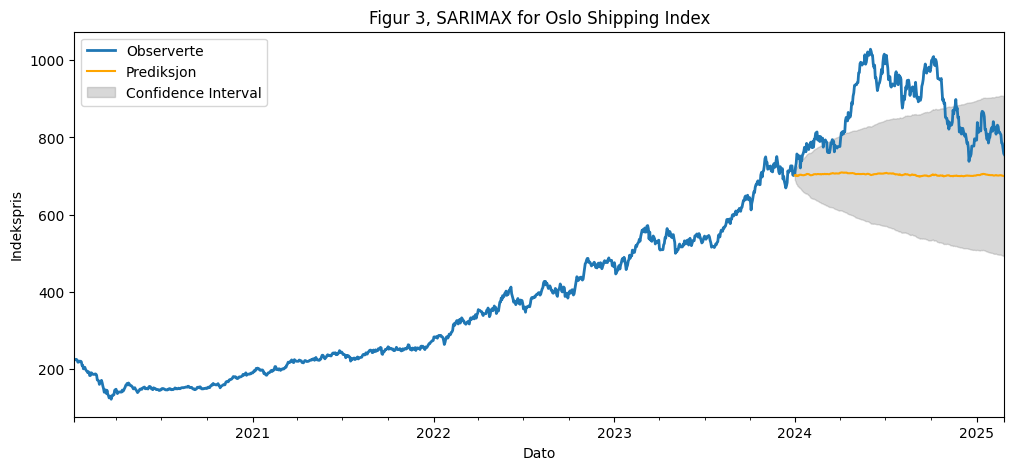

In [14]:
# Plotter SARIMAX forecast med CI
fig, ax = plt.subplots(figsize=(12, 5))

# Hele observasjonsperioden
y_series = merged['ShipPrice']
y_series.plot(ax=ax, label='Observerte', linewidth=2)

# Forecast, lik lengde som sarimax_pred
sarimax_pred.plot(ax=ax, label='Prediksjon', color='orange')

# 95% Konfidensintervall fra statsmodels
ci = sarimax_fc.conf_int()
ax.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1],
                color='gray', alpha=0.3, label='Confidence Interval')

# estetikk
ax.set_title('Figur 3, SARIMAX for Oslo Shipping Index')
ax.set_xlabel('Dato')
ax.set_ylabel('Indekspris')
ax.legend()
plt.show()

Figur 3 viser SARIMAX prediksjonene med et 95% konfidensintervall. Som vi kan se ut ifra den oransje linjen samt konfidensintervallet klarte ikke SARIMAX’en og predikere shipping prisen særlig bra. Store deler av test-dataen, altså langt over 5%, havner utenfor konfidensintervallet, noe som tilsier at prediksjonen ikke fungerer. SARIMAX modellen predikerer en svært konstant utvikling i prisen til shipping indeksen, med minimale svingninger.

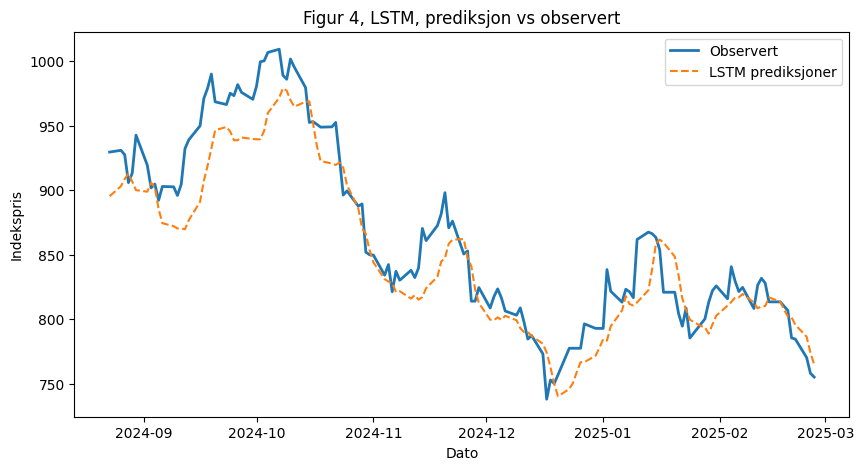

In [20]:
# Plot LSTM predictions vs. actual on test‑sett
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(dates_test, lstm_truth.values, label='Observert', linewidth=2)
ax.plot(dates_test, lstm_pred, label='LSTM prediksjoner', linestyle='--')
ax.set_title('Figur 4, LSTM, prediksjon vs observert')
ax.set_xlabel('Dato')
ax.set_ylabel('Indekspris')
ax.legend()
plt.show()


Figur 4 viser hvordan LSTM modellen predikerte shipping indeksen fra september 2024 - mars 2025. Den blå linjen viser de faktiske verdiene, mens den gule stripete linjen er prediksjonen til modellen. Som vi kan se ut ifra plottet så følger linjene hverandre veldig klart gjennom hele prosessen, noe som tilsier at LSTM modellen fint klarer å predikere shipping.

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


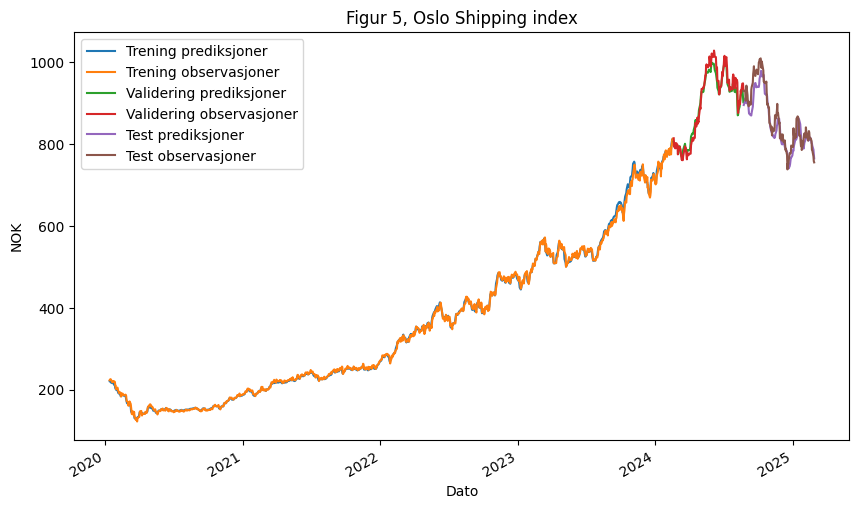

In [22]:
# Sammensatt plot med hele prosessen

# Skaler tilbake LSTM-prediksjonene
train_pred_scaled = lstm_model.predict(X_train).flatten()
val_pred_scaled   = lstm_model.predict(X_val).flatten()
test_pred_scaled  = lstm_model.predict(X_test).flatten()

def invert_scale(pred_scaled, oil_scaled_slice):
    return scaler.inverse_transform(
        np.column_stack([pred_scaled, oil_scaled_slice])
    )[:, 0]

train_pred = invert_scale(train_pred_scaled,
                          merged['OilPrice_scaled'].iloc[:len(train_pred_scaled)])
val_pred   = invert_scale(val_pred_scaled,
                          merged['OilPrice_scaled'].iloc[len(train_pred_scaled):
                                                         len(train_pred_scaled)+len(val_pred_scaled)])
test_pred  = invert_scale(test_pred_scaled,
                          merged['OilPrice_scaled'].iloc[-len(test_pred_scaled):])

# tilsvarende observerte verdier
train_obs = merged['ShipPrice'].iloc[:len(train_pred)]
val_obs   = merged['ShipPrice'].iloc[len(train_pred):
                                     len(train_pred)+len(val_pred)]
test_obs  = merged['ShipPrice'].iloc[-len(test_pred):]

# plot
plt.figure(figsize=(10, 6))
plt.plot(dates_train, train_pred, label='Trening prediksjoner')
plt.plot(dates_train, train_obs,  label='Trening observasjoner')

plt.plot(dates_val,   val_pred,   label='Validering prediksjoner')
plt.plot(dates_val,   val_obs,    label='Validering observasjoner')

plt.plot(dates_test,  test_pred,  label='Test prediksjoner')
plt.plot(dates_test,  test_obs,   label='Test observasjoner')

plt.title('Figur 5, Oslo Shipping index')
plt.xlabel('Dato')
plt.ylabel('NOK')
plt.legend()
plt.gcf().autofmt_xdate()   # roter datoetiketter pent
plt.show()

Figur 5 viser hele prosessen til LSTM modellen. Den starter med den oransje linjen der modellen trener på dataen. Treningsprosessen avsluttes og går over til neste fasen som er valideringen. Det er den røde linjen som viser dette visuelt, og her får treningsdataen nye forhold (Apmonitor, 2022). Til slutt kommer den testen som vi observerte i figur 4.

# Evaluering av modeller

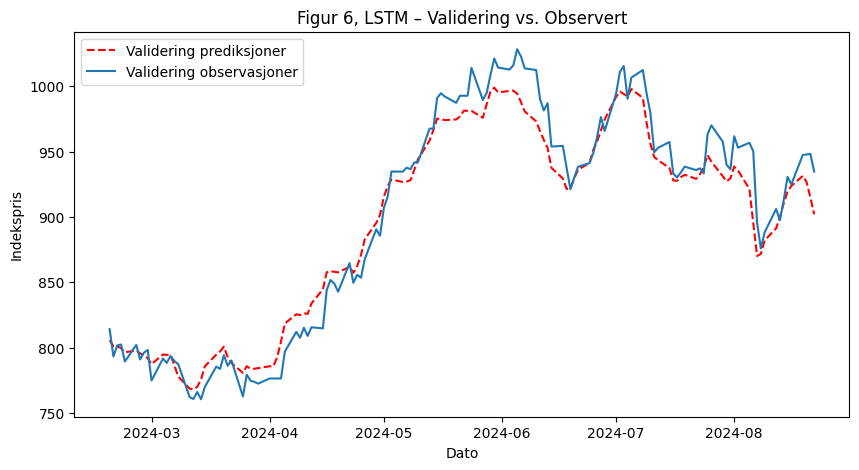

In [23]:
# Plot validerings data
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(dates_val,   val_pred, 'r',  label='Validering prediksjoner', linestyle='--')
plt.plot(dates_val,   val_obs,    label='Validering observasjoner')
ax.set_title('Figur 6, LSTM – Validering vs. Observert')
ax.set_xlabel('Dato')
ax.set_ylabel('Indekspris')
ax.legend()
plt.show()

I figur 6 kan vi se dataen LSTM modellen evalueres på og inneholder de verdiene vi bruker til å regne ut RMSE og MAE. Prediksjonene følger observasjonene veldig tett, noe som er lovende for evalueringen.

Root mean squared error (RMSE) og Mean absolute error (MAE) er to kritiske evalueringsmetoder. Zhang (2024) brukte disse to for å vurdere LSTM vs ARIMA, hvilket er derfor vi velger å bruke de samme. RMSE regner ut forskjellen mellom de predikerte verdiene med de observerte verdiene (Balas et al., 2022). Desto lavere tall, desto mer nøyaktig er modellen. MAE regner ut den gjennomsnittlige størrelsen av de absolutte errorene i modellene mellom de predikerte og absolutte verdiene (Balas et al., 2022). Her gjelder det også å få tall så nærme 0 som mulig.

In [18]:
# kalkulerer evalueringskriterier
lstm_mse  = mean_squared_error(lstm_truth, lstm_pred)
lstm_rmse = math.sqrt(lstm_mse)
lstm_mae  = mean_absolute_error(lstm_truth, lstm_pred)
# printer
print(f"LSTM – RMSE: {lstm_rmse:.2f}  MAE: {lstm_mae:.2f}  MSE: {lstm_mse:.2f}")

LSTM – RMSE: 26.47  MAE: 20.92  MSE: 700.48


LSTM modellen har en RMSE på 26.47 og en MAE på 20.92. Begge evalueringsmetodene scoret lavt noe som tilsier at prediksjonen er ganske nøyaktig.

In [19]:
# Kalkulerer mse, rmse, mae for evaluering
sarimax_mse  = mean_squared_error(sarimax_truth, sarimax_pred)
sarimax_rmse = math.sqrt(sarimax_mse)
sarimax_mae  = mean_absolute_error(sarimax_truth, sarimax_pred)

print(f"SARIMAX – RMSE: {sarimax_rmse:.2f}   MAE: {sarimax_mae:.2f}   MSE: {sarimax_mse:.2f}")

SARIMAX – RMSE: 186.93   MAE: 167.24   MSE: 34941.64


SARIMAX har en RMSE på 186.93 og en MAE på 167.24. Dette er betydelig høyere tall enn det var på LSTM modellen. Dette vil si at SARIMAX modellen ikke predikerer like nøyaktig.

# Matematisk beskrivelse av modeller

## Sarimax mean-equation

𝚢ₜ representerer daglig shipping indeks priser på handelsdager $t$, og $x_t$ er de samtidige prisene for WTI crude-oil.

Vår spesifisering er en Seasonal ARIMA med en eksogen regressor: SARIMAX(p,d,q)(P,D,Q,s), som er hentet fra Chatfield (2003):

$\Theta(L)^{p}\,\theta(L^{s})^{P}\,\Delta^{d}\,\Delta_{s}^{D}y_{t}
\;=\;
\Phi(L)^{q}\,\phi(L^{s})^{Q}\,\Delta^{d}\,\Delta_{s}^{D}\varepsilon_{t}
\;+\;
\sum_{i=1}^{n}\beta_{i}x_{t}^{\,i}$


Her er $L$ lags

$s = 5$ handelsdager

$\phi_1=-0.6547$ sesongmessig AR(1)

$\theta_1=+0.7179$ sesongmessig MA(1)

$\varepsilon_t\sim\text{i.i.d.}(0,\sigma^2)$ forecast error

Ligningen antyder at indeksens endring i dag bestemmes av:

1. mean-reverting sesongmessig komponent $\phi_1$
2. Sjokkeffekten fra forrige uke $\theta_1$
3. En oljepris-effekt $\beta \approx 0.52$


## LSTM

Den bivariate modellen vi har brukt i denne oppgaven har tatt inspirasjon fra Pavlov-Kagadejev et. al (2024). For hver handelsdag $t$ bruker vi den tidligere hidden state $h_{t-1}\in\mathbb{R}^{64}$ med input-vektoren som inneholder de skalerte verdiene: shipping indeks og oljepris. Modellen regner ut følgende:



$\begin{aligned}
\text{Forget gate:}&\quad
f_t = \sigma\!\bigl(W_f [h_{t-1};x_t] + b_f\bigr)\\
\text{Input gate:}&\quad
i_t = \sigma\!\bigl(W_i [h_{t-1};x_t] + b_i\bigr)\\
\text{Candidate cell:}&\quad
\tilde C_t = \tanh\!\bigl(W_c [h_{t-1};x_t] + b_c\bigr)\\
\text{Cell state:}&\quad
C_t = f_t \odot C_{t-1} \;+\; i_t \odot \tilde C_t\\
\text{Output gate:}&\quad
o_t = \sigma\!\bigl(W_o [h_{t-1};x_t] + b_o\bigr)\\
\text{Hidden state:}&\quad
h_t = o_t \odot \tanh(C_t)
\end{aligned}$


"Her er $ \sigma(z)=1/(1+e^{-z})$ aktiveringsfunksjonen Sigmoid. $\tanh(\cdot)$ den hyperbolske tangenten og $\odot$ indikerer den elementvise multiplikasjonen" (Pavlov-Kagadejev et. al, 2024).

I forget gaten $f_t$ bestemmes hvor mye av den tidligere informasjonen fra Cell state $C_{t-1}$ som skal beholdes. Input gaten $i_t$ styrer Candidate cellen $\tilde C_t$ sin betydning og output gaten $o_t$ bestemmer hva som skal sendes videre fra LSTM cellen til det neste laget. (Aase, 2024). Ved bruk av tanh funksjonen blir $C_t$ skalert til [-1,1]. Denne vektoren blir multiplisert med output gaten $o_t$ og regner ut hidden gate $h_t$, som aktiveres av ReLU og resulterer i en prediksjon for neste dags indekspris (Pavlov-Kagadejev et. al, 2024).

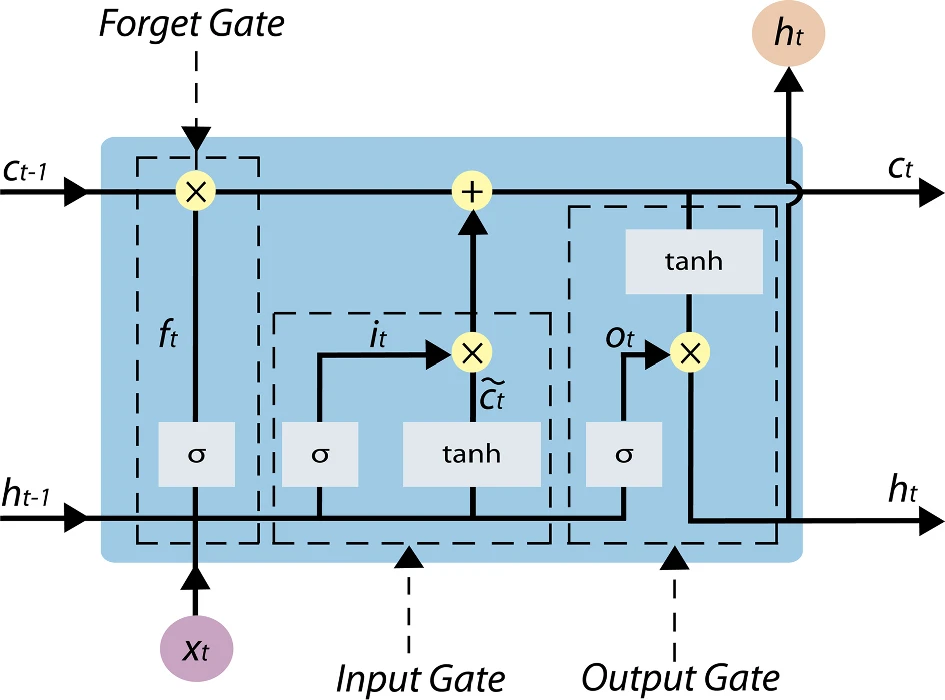

Figur 7, Pavlov-Kagadejev et. al, 2024.

##   Konklusjon og refleksjon  

I denne oppgaven tok vi for oss problemstillingen “er shipping indeksen forutsigbar en dag eller en uke før i tid?” For å svare på dette tok vi i bruk to modeller, en dyplæringsteknikk, LSTM, og en mindre kompleks tidsserie modell, SARIMAX. Ved å analysere figurene 3 og 4 kan vi konkludere med at LSTM modellen klarer å predikere shipping indeksen veldig nøyaktig, mens SARIMAX modellen var noe mer unøyaktig. Dette ble også støttet av RMSE og MAE som er evalueringsmetodene som ble tatt i bruk, der begge viste lavere tall for den førstnevnte modellen. Ut ifra de testene vi har gjort, er LSTM modellen betydelig bedre til å predikere indeksprisen sammenlignet med SARIMAX. LSTM modellen har en evne til å kapre ikke-lineære forhold, hvor SARIMAX er begrenset ved å ha en lineær struktur. Det kunne også vært hensynsmessig å legge til et konfidensintervall i LSTM modellen. Modellen er bygget på en slik måte at den predikerer kortsiktig. Shipping markedet er enda tungt avhengig av oljemarkedet, men det er mye press på shippingselskapene til å endre til mer miljøvennlige alternativer.

I vårt tilfelle var det betydelig forskjell på modellene. Om vi hadde inkludert flere eksogene variabler samt lagt til flere lags kunne tidsserie modellen prestert bedre, men dette argumentet kan gjøres for begge modellene. LSTM modellen vår predikerte såpass nøyaktig at shipping indeksen virker veldig forutsigbar og at denne modellen fint kan brukes i praksis. Ytelsen trenger definitivt flere tester ettersom resultatene virker skremmende gode. Samtidig, ved bruk av en "early stopping" funksjon, har vi gjort steg for å unngå overfitting av modellen. Figur 4 viser også hvordan de predikerte verdiene følger en veldig lik trend som de observerte.

En kortsiktig prediksjonsmodell for Oslo børs shipping indeks med høy nøyaktighet kan være av verdi til flere markedsaktører. For en børsmegler kan nytten være stor i sammenheng med handelsstrategier og timing i markedet til norske shipping akjser. Samtidig er det viktig å bemerke seg at vår LSTM modell ikke inneholder et konfidensintervall, noe som hadde hjulpet med risikovurderingen av investeringene. Funnene kan også gi verdifull innsikt til hvordan oljeprisen henger sammen med shipping indeksen. Dette kan være til nytte når det kommer til reguleringer innen oljebransjen og hvordan det kunne påvirket shipping bransjen.

## Referanseliste

Aase, M. J. (2024). Maskinlæring for økonomer: *Kompendium i SOK-3023. (s. 49-51)*.

Apmonitor. (2022, 03. Mars). *LSTM Networks*. Dynamic Optimization.
https://apmonitor.com/do/index.php/Main/LSTMNetwork

Balas, V,. Gupta, K,. Khanna, A. & Kose, U. (2022). *Deep Learning for Medical Applications with Unique Data*. Elsevier
https://www.sciencedirect.com/topics/engineering/root-mean-square-error

Balas, V., Ghosh, A., Mekhilef, S. & Shaw, R. (2022). *Applications of AI and IOT in Renewable Energy*. Elsevier
https://www.sciencedirect.com/topics/engineering/mean-absolute-error

Chatfield, C. (2003). *The Analysis of Time Series*. Chapman and Hall/CRC. https://doi.org/10.4324/9780203491683

Choi, K.-H., & Yoon, S.-M. (2020). *Asymmetric Dependence between Oil Prices and Maritime Freight Rates: A Time-Varying Copula Approach. Sustainability*, 12(24), 10687. https://doi.org/10.3390/su122410687

GoogleAI. (2023). *Gemini* (6. mai versjon) [AI assistant for Google Colab]. https://gemini.google.com/  

Krohn, O. (2021, 27 mai). *Sykliske aksjer – hva er det og hvorfor investere i dem?* DNB
https://www.dnb.no/dnbnyheter/no/bors-og-marked/sykliske-aksjer

Investing.com. (2025). *Crude Oil WTI*. [Crude Oil WTI Futures Historical Data.csv]. Investing.com. https://www.investing.com/commodities/crude-oil

Investing.com. (2025). *Oslo Shipping*. [OSLO Shipping Historical Data.csv]. Investing.com. https://www.investing.com/indices/oslo-shipping

Mehandzhiyski, V. (2023, 21 april). *What is a SARIMAX model?* 365datascience
https://365datascience.com/tutorials/python-tutorials/sarimax/

Mehandzhiyski, V. (2023, 21 april). *What is an ARIMAX model?* 365datascience
https://365datascience.com/tutorials/python-tutorials/arimax/

OpenAI. (2023). *ChatGPT* (6. mai versjon) [o3]. https://chat.openai.com/

Pavlov-Kagadejev, M., Jovanovic, L., Bacanin, N., Deveci, M., Zivkovic, M., Tuba, M., Strumberger, I., & Pedrycz, W. (2024). Optimizing long-short-term memory models via metaheuristics for decomposition aided wind energy generation forecasting. *Artificial Intelligence Review*, 57(3), 45. https://doi.org/10.1007/s10462-023-10678-y

Shumway, R. -H. & Stoffer, D. -S. (2017). *Time Series Analysis and Its Applications: With R Examples*. (4.utg.). Springer
https://link.springer.com/chapter/10.1007/978-3-319-52452-8_3

Westrum, U. A., & Ørnes, T. (2022). *Momentum & Mean reversion. En kombinert handelsstrategi testet på Oslo Børs*(Master's thesis, OsloMet–storbyuniversitetet).
https://link.springer.com/article/10.1007/s10462-023-10678-y

Zhang, Z. (2024). Comparison of LSTM and ARIMA in Price Forecasting: Evidence from Five Indexes. I F. Balli, H. N. Au Yong, S. Ali Qalati, & Z. Zeng (Red.), *Proceedings of the 2023 2nd International Conference on Economics, Smart Finance and Contemporary Trade (ESFCT 2023)* (Bd. 261, s. 40–46). Atlantis Press International BV. https://doi.org/10.2991/978-94-6463-268-2_6